In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

In [ ]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [ ]:
train_grouped = train_df.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()
test_grouped = test_df.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()

In [ ]:
# Kiểm định tính dừng bằng Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    return result[1] < 0.05  # Trả về True nếu dữ liệu dừng

if not adf_test(train_grouped['Units']):
    train_grouped['Units'] = train_grouped['Units'].diff().dropna()
if not adf_test(train_grouped['Revenue']):
    train_grouped['Revenue'] = train_grouped['Revenue'].diff().dropna()

In [ ]:
# Xác định giá trị tối ưu của (p, d, q)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))

best_order_units = min(pdq, key=lambda order: ARIMA(train_grouped['Units'].dropna(), order=order).fit().aic)
best_order_revenue = min(pdq, key=lambda order: ARIMA(train_grouped['Revenue'].dropna(), order=order).fit().aic)



In [ ]:
# Dự báo với ARIMA
arima_model_units = ARIMA(train_grouped['Units'].dropna(), order=best_order_units).fit()
arima_pred_units = arima_model_units.forecast(steps=len(test_grouped))

arima_model_revenue = ARIMA(train_grouped['Revenue'].dropna(), order=best_order_revenue).fit()
arima_pred_revenue = arima_model_revenue.forecast(steps=len(test_grouped))

In [ ]:
# Kiểm tra xem có giá trị NaN trong dữ liệu hay không
print(train_grouped.isnull().sum())

# Loại bỏ hoặc điền giá trị NaN
train_grouped = train_grouped.dropna()  # Hoặc thay thế bằng train_grouped.fillna(method='ffill')


In [ ]:
# Dự báo với Linear Regression
X = np.array(train_grouped.index).reshape(-1, 1)
y_units = train_grouped['Units']
y_revenue = train_grouped['Revenue']

lin_reg_units = LinearRegression().fit(X, y_units)
lin_reg_pred_units = lin_reg_units.predict(X)

lin_reg_revenue = LinearRegression().fit(X, y_revenue)
lin_reg_pred_revenue = lin_reg_revenue.predict(X)

In [ ]:
# Dự báo với XGBoost
dmatrix_units = xgb.DMatrix(X, label=y_units)
dmatrix_revenue = xgb.DMatrix(X, label=y_revenue)

params = {'objective': 'reg:squarederror'}
xgb_model_units = xgb.train(params, dmatrix_units, num_boost_round=100)
xgb_pred_units = xgb_model_units.predict(dmatrix_units)

xgb_model_revenue = xgb.train(params, dmatrix_revenue, num_boost_round=100)
xgb_pred_revenue = xgb_model_revenue.predict(dmatrix_revenue)

In [ ]:
# Dự báo với Prophet
df_prophet_units = train_grouped.rename(columns={'Date': 'ds', 'Units': 'y'})
df_prophet_revenue = train_grouped.rename(columns={'Date': 'ds', 'Revenue': 'y'})

prophet_units = Prophet().fit(df_prophet_units)
prophet_pred_units = prophet_units.predict(df_prophet_units)['yhat']

prophet_revenue = Prophet().fit(df_prophet_revenue)
prophet_pred_revenue = prophet_revenue.predict(df_prophet_revenue)['yhat']

In [ ]:
# Dự báo với LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_grouped[['Units', 'Revenue']])

X_lstm, y_lstm = [], []
for i in range(10, len(scaled_data)):
    X_lstm.append(scaled_data[i-10:i])
    y_lstm.append(scaled_data[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 2)),
    LSTM(50, activation='relu'),
    Dense(2)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm, y_lstm, epochs=50, batch_size=16)

In [ ]:
# Đánh giá mô hình
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}")

evaluate_model(y_units, lin_reg_pred_units, "Linear Regression - Units")
evaluate_model(y_revenue, lin_reg_pred_revenue, "Linear Regression - Revenue")
evaluate_model(y_units, xgb_pred_units, "XGBoost - Units")
evaluate_model(y_revenue, xgb_pred_revenue, "XGBoost - Revenue")
evaluate_model(y_units, prophet_pred_units, "Prophet - Units")
evaluate_model(y_revenue, prophet_pred_revenue, "Prophet - Revenue")

In [ ]:
# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
plt.plot(y_units, label='Actual Units')
plt.plot(lin_reg_pred_units, label='Linear Regression')
plt.plot(xgb_pred_units, label='XGBoost')
plt.plot(prophet_pred_units, label='Prophet')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

# Định nghĩa hàm đánh giá

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}")

# Linear Regression
X = np.array((train_grouped.index).astype(float)).reshape(-1, 1)
y_units = train_grouped['Units']
y_revenue = train_grouped['Revenue']

lin_reg_units = LinearRegression().fit(X, y_units)
lin_reg_pred_units = lin_reg_units.predict(X)
evaluate_model(y_units, lin_reg_pred_units, "Linear Regression - Units")

lin_reg_revenue = LinearRegression().fit(X, y_revenue)
lin_reg_pred_revenue = lin_reg_revenue.predict(X)
evaluate_model(y_revenue, lin_reg_pred_revenue, "Linear Regression - Revenue")

# XGBoost
params_list = [
    {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100},
    {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 200},
]
for params in params_list:
    xgb_model_units = xgb.XGBRegressor(**params).fit(X, y_units)
    xgb_pred_units = xgb_model_units.predict(X)
    evaluate_model(y_units, xgb_pred_units, f"XGBoost - Units (params: {params})")

# Prophet
df_prophet_units = train_grouped.rename(columns={'Date': 'ds', 'Units': 'y'})
prophet_units = Prophet()
prophet_units.fit(df_prophet_units)
future = prophet_units.make_future_dataframe(periods=365)
forecast = prophet_units.predict(future)

# ARIMA
result = adfuller(train_grouped['Units'])
if result[1] > 0.05:
    train_grouped['Units'] = train_grouped['Units'].diff().dropna()

auto_arima_model = pm.auto_arima(train_grouped['Units'].dropna(), seasonal=False, stepwise=True, suppress_warnings=True)
order = auto_arima_model.order
arima_model = ARIMA(train_grouped['Units'].dropna(), order=order).fit()
arima_pred = arima_model.predict(start=len(train_grouped), end=len(train_grouped) + 30)

# LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_grouped[['Units', 'Revenue']])
X_lstm, y_lstm = [], []
for i in range(10, len(scaled_data)):
    X_lstm.append(scaled_data[i-10:i])
    y_lstm.append(scaled_data[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 2)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(2)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm, y_lstm, epochs=50, batch_size=16)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_grouped['Date'], y=train_grouped['Units'], label='Actual Units')
sns.lineplot(x=train_grouped['Date'], y=lin_reg_pred_units, label='Linear Regression')
sns.lineplot(x=train_grouped['Date'], y=xgb_pred_units, label='XGBoost')
plt.title('Comparison of Models for Unit Sales Prediction')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt



# Gom nhóm dữ liệu theo ngày
train_grouped = train_df.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()

# Tạo các đặc trưng bổ sung
train_grouped['lag_1'] = train_grouped['Units'].shift(1)
train_grouped['lag_7'] = train_grouped['Units'].shift(7)
train_grouped['rolling_mean_7'] = train_grouped['Units'].rolling(window=7).mean()
train_grouped.dropna(inplace=True)

# Chuẩn bị dữ liệu
X = train_grouped[['lag_1', 'lag_7', 'rolling_mean_7']]
y_units = train_grouped['Units']

X_train, X_test, y_train, y_test = train_test_split(X, y_units, test_size=0.2, random_state=42)

# Tìm tham số tối ưu cho XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Huấn luyện XGBoost với tham số tối ưu
xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Dự báo
xgb_pred = xgb_model.predict(X_test)

# Đánh giá mô hình
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}")

evaluate_model(y_test, xgb_pred, "XGBoost")

# Vẽ biểu đồ so sánh dự báo
plt.figure(figsize=(12, 6))
plt.plot(train_grouped['Date'][-len(y_test):], y_test.values, label='Actual Units')
plt.plot(train_grouped['Date'][-len(y_test):], xgb_pred, label='XGBoost Prediction', linestyle='dashed')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('XGBoost Prediction vs Actual Data')
plt.show()


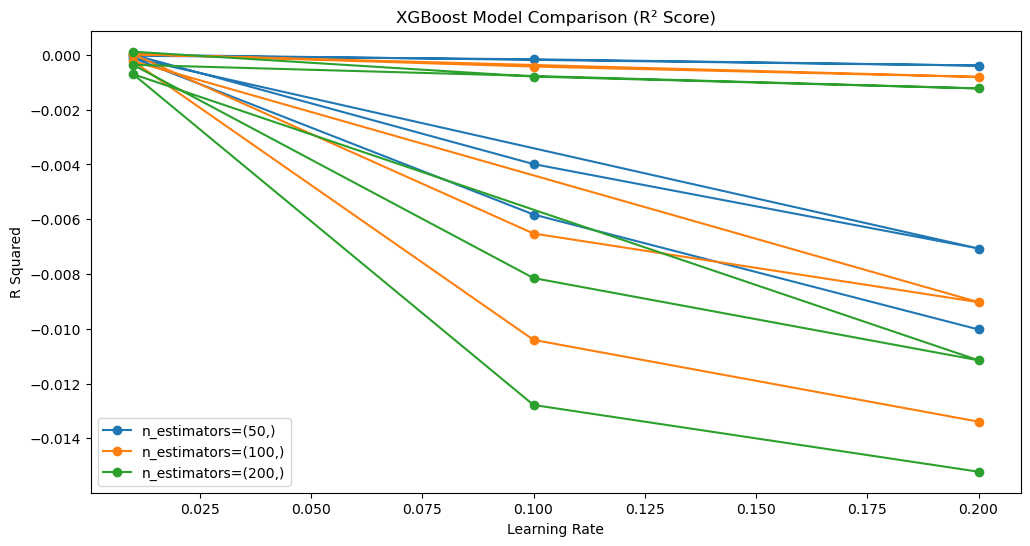

Best Parameters: {'n_estimators': 200.0, 'max_depth': 3.0, 'learning_rate': 0.01}
Best R2: 0.00011401169854519111
Best MAPE: 0.03663153915732984
Best RMSE: 0.32022096541389755


In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from itertools import product

# Load data
train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", parse_dates=['Date'])
test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", parse_dates=['Date'])

# Feature Engineering
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day

# Define features and target
features = ['Year', 'Month', 'Day']
target = 'Units'  # Hoặc 'Revenue' tùy vào mục tiêu

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Train multiple models and compare
results = []
for n_est, max_d, lr in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['learning_rate']):
    params = {'n_estimators': n_est, 'max_depth': max_d, 'learning_rate': lr}
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({'n_estimators': n_est, 'max_depth': max_d, 'learning_rate': lr, 'R2': r2, 'MAPE': mape, 'RMSE': rmse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
best_model = results_df.sort_values(by='R2', ascending=False).iloc[0]  # Lấy model có R2 cao nhất

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
for key, grp in results_df.groupby(['n_estimators']):
    ax.plot(grp['learning_rate'], grp['R2'], marker='o', label=f'n_estimators={key}')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('R Squared')
ax.set_title('XGBoost Model Comparison (R² Score)')
ax.legend()
plt.show()

print("Best Parameters:", best_model[['n_estimators', 'max_depth', 'learning_rate']].to_dict())
print("Best R2:", best_model['R2'])
print("Best MAPE:", best_model['MAPE'])
print("Best RMSE:", best_model['RMSE'])


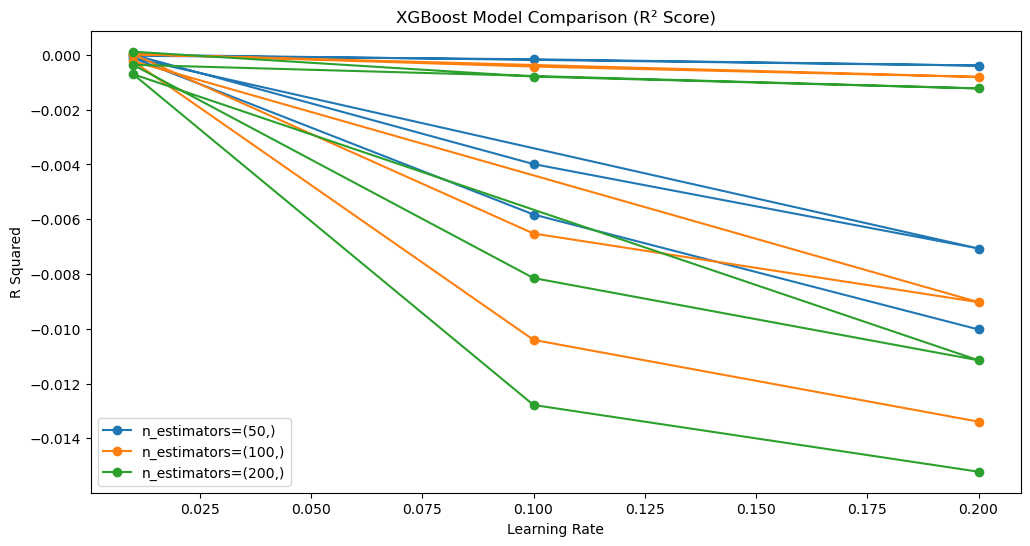

Best Parameters: {'n_estimators': 200.0, 'max_depth': 3.0, 'learning_rate': 0.01}
Best R2: 0.00011401169854519111
Best MAPE: 0.03663153915732984
Best RMSE: 0.32022096541389755


In [25]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from itertools import product

# Load data
train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", parse_dates=['Date'])
test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", parse_dates=['Date'])

# Feature Engineering
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day

# Define features and target
features = ['Year', 'Month', 'Day']
target = 'Units'  # Hoặc 'Revenue' tùy vào mục tiêu

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Train multiple models and compare
results = []
for n_est, max_d, lr in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['learning_rate']):
    params = {'n_estimators': n_est, 'max_depth': max_d, 'learning_rate': lr}
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({'n_estimators': n_est, 'max_depth': max_d, 'learning_rate': lr, 'R2': r2, 'MAPE': mape, 'RMSE': rmse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
best_model = results_df.sort_values(by='R2', ascending=False).iloc[0]  # Lấy model có R2 cao nhất

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
for key, grp in results_df.groupby(['n_estimators']):
    ax.plot(grp['learning_rate'], grp['R2'], marker='o', label=f'n_estimators={key}')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('R Squared')
ax.set_title('XGBoost Model Comparison (R² Score)')
ax.legend()
plt.show()

print("Best Parameters:", best_model[['n_estimators', 'max_depth', 'learning_rate']].to_dict())
print("Best R2:", best_model['R2'])
print("Best MAPE:", best_model['MAPE'])
print("Best RMSE:", best_model['RMSE'])

Epoch 1/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 347s 24ms/step - loss: 5.4305e-04
Epoch 2/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 316s 22ms/step - loss: 4.7232e-05
Epoch 3/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 260s 18ms/step - loss: 4.8373e-05
Epoch 4/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 229s 16ms/step - loss: 4.8934e-05
Epoch 5/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 231s 16ms/step - loss: 4.6191e-05
Epoch 6/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 213s 15ms/step - loss: 4.9961e-05
Epoch 7/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 214s 15ms/step - loss: 4.9061e-05
Epoch 8/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 219s 16ms/step - loss: 4.5752e-05
Epoch 9/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 236s 17ms/step - loss: 4.7800e-05
Epoch 10/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 228s 16ms/step - loss: 4.8357e-05
Epoch 11/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 227s 16ms/step - loss: 4.8526e-05
Epoch 12/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 230s 16ms/step - loss: 4.6952e-05
Epoch 13/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 203s 14ms/step -

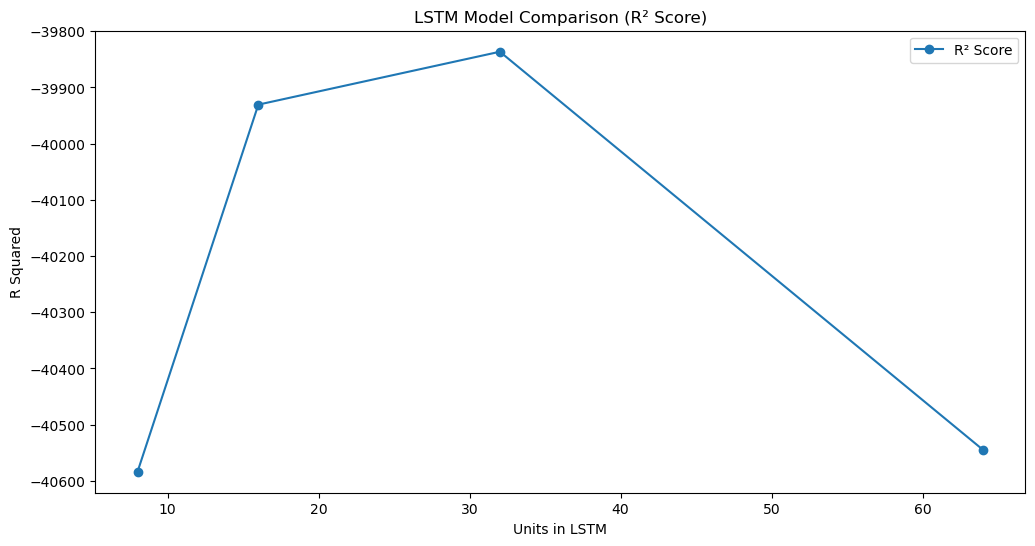

Best Parameters: {'Units': 32.0, 'Learning Rate': 0.001, 'Batch Size': 256.0}
Best R2: -39836.48071094371
Best MAPE: 4360243349628313.0
Best RMSE: 0.9831913463828283


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Load data
train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", parse_dates=['Date'])
test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", parse_dates=['Date'])

# Feature Engineering
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day

# Chọn cột sử dụng làm đặc trưng (features) và mục tiêu (target)
features = ['Year', 'Month', 'Day']
target = 'Units'  # Có thể thay bằng 'Revenue'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Chuẩn hóa dữ liệu bằng MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Chuyển dữ liệu thành dạng sequence cho LSTM
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Danh sách các bộ tham số thử nghiệm
param_grid = [
    (8, 0.0001, 64),
    (16, 0.0005, 128),
    (32, 0.001, 256),
    (64, 0.005, 512)
]

# Thêm EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

# Huấn luyện nhiều mô hình LSTM với các bộ tham số khác nhau
results = []
for units, lr, batch_size in param_grid:
    # Xây dựng mô hình LSTM với Input để tránh cảnh báo
    model = Sequential([
        Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        LSTM(units, return_sequences=True),
        Dropout(0.2),
        LSTM(units),
        Dropout(0.2),
        Dense(1)
    ])
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    
    # Huấn luyện mô hình với EarlyStopping
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Dự báo
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    # Đánh giá mô hình
    r2 = r2_score(y_test_seq, y_pred)
    mape = mean_absolute_percentage_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    
    results.append({
        'Units': units,
        'Learning Rate': lr,
        'Batch Size': batch_size,
        'R2': r2,
        'MAPE': mape,
        'RMSE': rmse
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
best_model = results_df.sort_values(by='R2', ascending=False).iloc[0]

# Vẽ biểu đồ so sánh R² Score
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_df['Units'], results_df['R2'], marker='o', linestyle='-', label='R² Score')

ax.set_xlabel('Units in LSTM')
ax.set_ylabel('R Squared')
ax.set_title('LSTM Model Comparison (R² Score)')
ax.legend()
plt.show()

print("Best Parameters:", best_model[['Units', 'Learning Rate', 'Batch Size']].to_dict())
print("Best R2:", best_model['R2'])
print("Best MAPE:", best_model['MAPE'])
print("Best RMSE:", best_model['RMSE'])


Epoch 1/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 1.5662e-05
Epoch 2/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 7.2125e-06
Epoch 3/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 4.6377e-06
Epoch 4/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 5.6177e-06
Epoch 5/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 4.0452e-06
Epoch 6/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 5.3537e-06
Epoch 7/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 5.1077e-06
Epoch 8/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 4.9091e-06
Epoch 9/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 4.4158e-06
Epoch 10/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 6.5554e-06
Epoch 11/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 3.7739e-06
Epoch 12/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 4.8308e-06
Epoch 13/50
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 6.4286e-06
Epoch 14/50
7044/7044 ━━━━━━━━━━━━

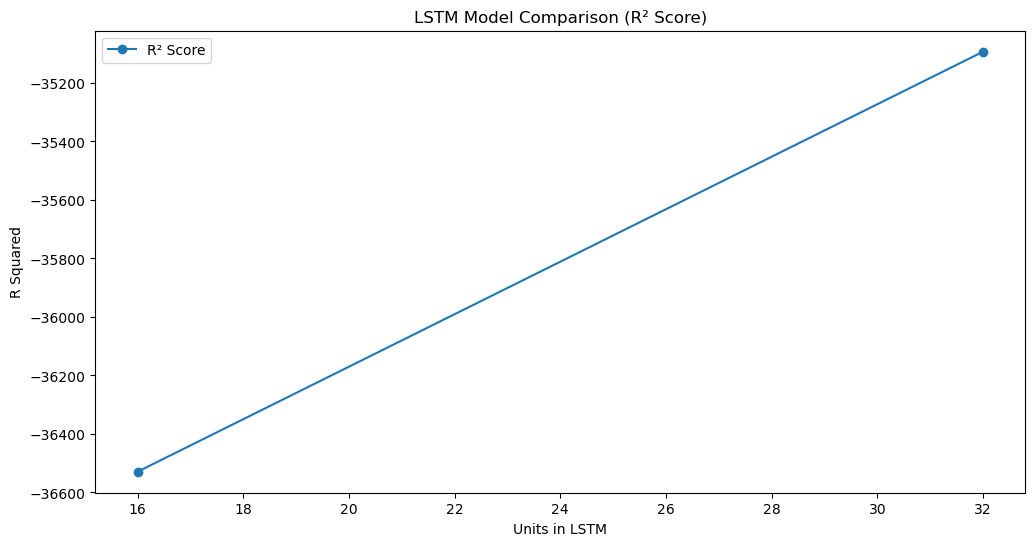

Best Parameters: {'Units': 32.0, 'Learning Rate': 0.0005, 'Batch Size': 256.0}
Best R2: -35093.10571457973
Best MAPE: 4432205410370904.5
Best RMSE: 1.0467175483715836


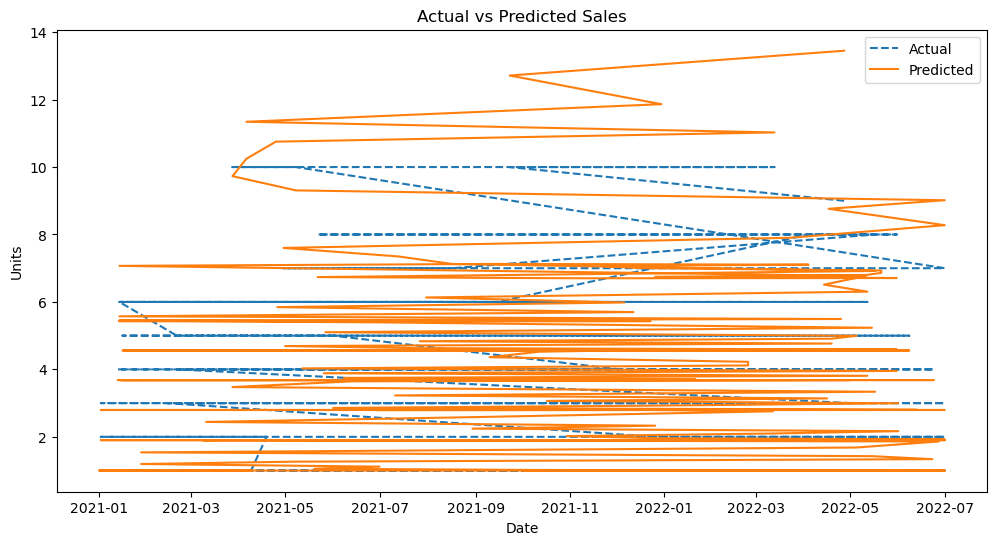

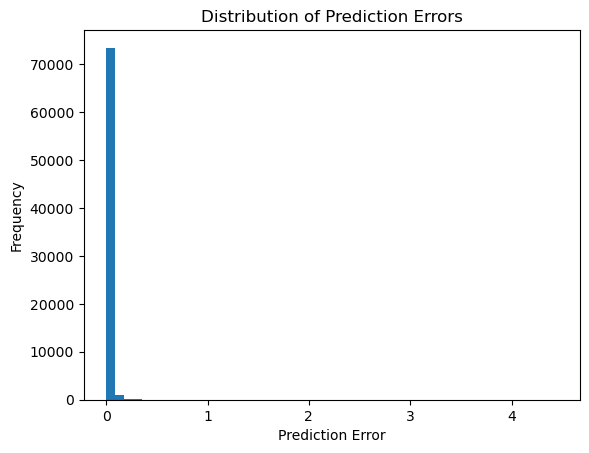

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Load data
train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", parse_dates=['Date'])
test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", parse_dates=['Date'])

# Feature Engineering: Thêm lag features & moving averages
train['Units_Lag_1'] = train['Units'].shift(1)
train['Units_Lag_7'] = train['Units'].shift(7)
train['Units_MA_7'] = train['Units'].rolling(7).mean()
train.dropna(inplace=True)  # Loại bỏ dòng NaN do shift & rolling

test['Units_Lag_1'] = test['Units'].shift(1)
test['Units_Lag_7'] = test['Units'].shift(7)
test['Units_MA_7'] = test['Units'].rolling(7).mean()
test.dropna(inplace=True)

# Chọn đặc trưng & target
features = ['Units_Lag_1', 'Units_Lag_7', 'Units_MA_7']
target = 'Units'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Chuẩn hóa dữ liệu (Chỉ fit trên tập train!)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Chuyển dữ liệu thành sequence cho LSTM
def create_sequences(X, y, time_steps=7):  # Giảm time_steps từ 30 -> 7
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7  # Giảm xuống để tránh mất quá nhiều dữ liệu
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Danh sách tham số thử nghiệm
param_grid = [
    (16, 0.0001, 128),
    (32, 0.0005, 256)
]

# EarlyStopping để tránh overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

# Huấn luyện mô hình LSTM
results = []
for units, lr, batch_size in param_grid:
    model = Sequential([
        Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        LSTM(units, return_sequences=False),
        Dropout(0.1),
        Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Dự báo
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    # Đánh giá mô hình
    r2 = r2_score(y_test_seq, y_pred)
    mape = mean_absolute_percentage_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    
    results.append({'Units': units, 'Learning Rate': lr, 'Batch Size': batch_size, 'R2': r2, 'MAPE': mape, 'RMSE': rmse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
best_model = results_df.sort_values(by='R2', ascending=False).iloc[0]

# Vẽ biểu đồ so sánh R² Score
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_df['Units'], results_df['R2'], marker='o', linestyle='-', label='R² Score')
ax.set_xlabel('Units in LSTM')
ax.set_ylabel('R Squared')
ax.set_title('LSTM Model Comparison (R² Score)')
ax.legend()
plt.show()

print("Best Parameters:", best_model[['Units', 'Learning Rate', 'Batch Size']].to_dict())
print("Best R2:", best_model['R2'])
print("Best MAPE:", best_model['MAPE'])
print("Best RMSE:", best_model['RMSE'])

# Kiểm tra kết quả dự đoán
test = test.iloc[time_steps:]
test['Predicted'] = y_pred.flatten()
test['Error'] = abs(test['Predicted'] - test[target])

# Biểu đồ dự đoán vs thực tế
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test[target], label='Actual', linestyle='--')
plt.plot(test['Date'], test['Predicted'], label='Predicted', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

# Phân phối lỗi dự đoán
plt.hist(test['Error'], bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()


In [2]:
# Feature Engineering
for df in [train, test]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

features = ['Year', 'Month', 'Day']
targets = ['Revenue', 'Units']

X_train, y_train = train[features], train[targets]
X_test, y_test = test[features], test[targets]

# Chuẩn hóa dữ liệu
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Chuyển dữ liệu thành sequence cho LSTM
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Xây dựng mô hình LSTM
model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.1),
    Dense(2)  # Output 2 giá trị: Revenue & Units
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)
model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=1, callbacks=[early_stopping])

# Dự báo
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Đánh giá mô hình
r2_revenue = r2_score(y_test_seq[:, 0], y_pred[:, 0])
r2_units = r2_score(y_test_seq[:, 1], y_pred[:, 1])
mape_revenue = mean_absolute_percentage_error(y_test_seq[:, 0], y_pred[:, 0])
mape_units = mean_absolute_percentage_error(y_test_seq[:, 1], y_pred[:, 1])

print(f"R² Revenue: {r2_revenue:.4f}, MAPE Revenue: {mape_revenue:.2f}")
print(f"R² Units: {r2_units:.4f}, MAPE Units: {mape_units:.2f}")

# Trực quan hóa dự báo vs. thực tế
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq[:, 0], label="Actual Revenue", color='blue')
plt.plot(y_pred[:, 0], label="Predicted Revenue", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Revenue")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_seq[:, 1], label="Actual Units", color='blue')
plt.plot(y_pred[:, 1], label="Predicted Units", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Units")
plt.show()


Epoch 1/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 160s 11ms/step - loss: 1.2007e-04
Epoch 2/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 153s 11ms/step - loss: 1.1088e-04
Epoch 3/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 124s 9ms/step - loss: 1.1220e-04
Epoch 4/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 123s 9ms/step - loss: 1.0573e-04
Epoch 5/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 137s 10ms/step - loss: 1.0954e-04
Epoch 6/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - loss: 1.0521e-04
Epoch 7/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - loss: 1.0558e-04
Epoch 8/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 125s 9ms/step - loss: 1.0334e-04
Epoch 9/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 148s 10ms/step - loss: 1.0421e-04
Epoch 10/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 157s 11ms/step - loss: 1.0550e-04
Epoch 11/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 167s 12ms/step - loss: 1.0558e-04
Epoch 12/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 216s 15ms/step - loss: 9.7699e-05
Epoch 13/50
14087/14087 ━━━━━━━━━━━━━━━━━━━━ 150s 11ms/step - loss

: 